# Effect of IQ matching

Verbal and performance IQ correlate with brain size in the general population. In ASD patients, however, verbal IQ does not seem to correlate with brain size. On the other hand, many studies of the neuroanatomy of autism match their case and control groups by IQ. Can this matching induce an overrepresentation of subjects with large brain volume among cases, and an underrepresentation of small brain volumes among controls?

We test this possibility by simulating two populations, one following the covariance pattern between VIQ, PIQ and BV observed among controls, the other following the covariance pattern observed among patients. The two populations are then ,matched by Full IQ (=(VIQ+PIQ)/2), and I look at the change in the power to find a difference in brain volume as a function of sample size.


## Import data

<b>data</b>: Nx4 matrix, 1 row per subject, 4 columns: Dx (1:ASD, 2:Ctrl), VIQ, PIQ, BV (mm3)<br>
    <b>ASD</b>: N<sub>asd</sub> vector, indices of ASD subjects within <b>data</b>
    <b>Ctrl</b>: N<sub>ctrl</sub> vector, indexes of Control subjects within <b>data</b>
</p>

In [1]:
%pylab inline

import numpy as np
import scipy.linalg as lin
import scipy.stats as sst
import pylab

# 1. Import the data, find ASD and Ctrl subjects
# columns are: Diagnostic, VIQ, PIQ, BV
data=np.genfromtxt("http://localhost/cc/data/viq-piq-bv.txt",skip_header=1);
ASD=np.nonzero(data[:,0]==1)[0]
Ctrl=np.nonzero(data[:,0]==2)[0]

Populating the interactive namespace from numpy and matplotlib


##Compute covariance matrices
<b>VA</b>: 3x3 matrix, covariance matrix between VIQ, PIQ and BV for ASD subjects<br>
<b>VC</b>: 3x3 matrix, covariance matrix between VIQ, PIQ, BV for Control subjects<br>

In [2]:
1# 2. Compute means and covariance matrices
if 0:
    # observed statistics
    muA=np.mean(data[ ASD,1:],axis=0);
    muC=np.mean(data[Ctrl,1:],axis=0);
    VA=np.cov(data[ASD,1:],rowvar=0);
    VC=np.cov(data[Ctrl,1:],rowvar=0);
if 1:
    # test statistics
    rPB=0.30  # correlation between PIQ and brain volume
    rVP=0.5   # correlation between VIQ and PIQ
    sV=sP=15  # standard deviation of VIQ and PIQ
    sB=100    # standard deviation of brain volume
    muA=np.array([100,110,1100]);
    muC=np.array([110,110,1100]);
    VA=np.array([[sV*sV,rVP*sV*sP,0],        [rVP*sV*sP,sP*sP,rPB*sP*sB],[0,rPB*sP*sB,sB*sB]])
    VC=np.array([[sV*sV,rVP*sV*sP,rPB*sV*sB],[rVP*sV*sP,sP*sP,rPB*sP*sB],[rPB*sV*sB,rPB*sP*sB,sB*sB]])
print "ASD means";
print muA;
print "Ctrl means";
print muC;
print "ASD covariance";
print VA;
print "Ctrl covariance matrix";
print VC;

ASD means
[ 100  110 1100]
Ctrl means
[ 110  110 1100]
ASD covariance
[[   225.     112.5      0. ]
 [   112.5    225.     450. ]
 [     0.     450.   10000. ]]
Ctrl covariance matrix
[[   225.     112.5    450. ]
 [   112.5    225.     450. ]
 [   450.     450.   10000. ]]


## Iterations
<b>N</b>: scalar, initial number of subjects in each group (before matching)

### Generate groups
<b>muA</b>: vector, mean VIQ, mean PIQ and mean BV for ASD<br>
<b>muC</b>: vector, mean VIQ, mean PIQ and mean BV for Controls<br>
<b>yA</b>: Nx3 matrix, values generated with mean muA and covariance matrix VA<br>
<b>yC</b>: Nx3 matrix, values generated with mean muC and covariance matric VC<br>
<b>iA</b>: N vector, with values from 0 to N-1<br>
<b>iC</b>: N vector, with values from 0 to N-1<br>

### Generate FIQ values
<b>FA</b>: N vector, with FIQ values for ASD<br>
<b>FC</b>: N vector, with FIQ values for Controls<br>

### Get the largest min and the smallest max to truncate the distributions
<b>minAC</b>: largest min between min(FIQ) ASD and min(FIQ) Controls<br>
<b>maxAC</b>: smallest max between max(FIQ) ASD and max(FIQ) Controls<br>
<br>
Now, the indices corresponding to samples in both groups where FIQ&lt;minAC and FIQ&gt;maxAC are deleted from <b>iA</b> and <b>iC</b>.<br>
<br>
<b>TMP</b>: 3x(Nia+Nic) matrix, 1st row: FIQ values, 2nd row: 1 for ASD, 2 for Ctrl, 3rd row: subject index in yA and yC (depending on the value of the 2nd row)<br>
<b>ind</b>: (Nia+Nic) vector with the re-arrangement of the indices that would sort TMP by FIQ.<br>
<br>
Now, the samples are matched by FIQ, and the new indices of matched subjects are placed in iA and iC<br>
<br>

In [32]:
# 3. Iterations
flagSave=0;
replications=1000;

#rPB=0.30  # correlation between PIQ and brain volume
rVP=0.5   # correlation between VIQ and PIQ
sV=sP=15  # standard deviation of VIQ and PIQ
sB=100    # standard deviation of brain volume
muA=np.array([100,110,1100]);
muC=np.array([110,110,1100]);

for irPB in range(0,5,1):
    rPB=0.30+0.05*irPB;
    VA=np.array([[sV*sV,rVP*sV*sP,0],        [rVP*sV*sP,sP*sP,rPB*sP*sB],[0,rPB*sP*sB,sB*sB]])
    VC=np.array([[sV*sV,rVP*sV*sP,rPB*sV*sB],[rVP*sV*sP,sP*sP,rPB*sP*sB],[rPB*sV*sB,rPB*sP*sB,sB*sB]])
    
    for N in range(100,1600,200):
        T=[]
        P=[]
        mean_N=0;
        mean_yMA=0;
        mean_yMC=0;
        for j in range(0,replications):
            # generate ASD and Ctrl subjects after the observed
            # covariance matrices
            yA=np.random.multivariate_normal(muA,VA,size=N)
            yC=np.random.multivariate_normal(muC,VC,size=N)
            if flagSave:
                np.savetxt("/Users/roberto/Desktop/sim-unmatched-md-800.txt",np.concatenate([np.concatenate([yA.T,np.ones([1,yA.T.shape[1]])]),np.concatenate([yC.T,2*np.ones([1,yC.T.shape[1]])])],axis=1).T,fmt="%g",delimiter="\t");
        
            # generate FIQ values
            FA=0.5*yA[:,0]+0.5*yA[:,1]
            FC=0.5*yC[:,0]+0.5*yC[:,1]
    
            # get the largest min, and the smallest max to truncate the distributions
            minA=np.min(FA);
            maxA=np.max(FA);
            minC=np.min(FC);
            maxC=np.max(FC);
            if(minA<minC):
                minAC=minC
            else:
                minAC=minA
            if(maxA>maxC):
                maxAC=maxC
            else:
                maxAC=maxA
            iA=range(0,N)
            iC=range(0,N)
            iA=np.delete(iA,np.nonzero(FA<minAC))
            iA=np.delete(iA,np.nonzero(FA>maxAC))
            iC=np.delete(iC,np.nonzero(FC<minAC))
            iC=np.delete(iC,np.nonzero(FC>maxAC))
        
            # concatenate both populations and sort them by FIQ
            TMPA=np.concatenate([[FA[iA]],[1*np.ones(iA.shape,dtype=int)],[iA]])
            TMPC=np.concatenate([[FC[iC]],[2*np.ones(iC.shape,dtype=int)],[iC]])
            TMP=np.concatenate([TMPA,TMPC],axis=1)
            ind=np.argsort(TMP)[0,:]
        
            # pick one from one group, one from the other
            MATCHED=np.array([TMP[:,ind[0]]]);
            old=TMP[1,ind[0]];
            for i in range(1,TMP.shape[1]):
                if TMP[1,ind[i]]!=old:
                    old=TMP[1,ind[i]]
                    MATCHED=np.concatenate([MATCHED,np.array([TMP[:,ind[i]]])])
            iA=MATCHED[np.nonzero(MATCHED[:,1]==1)[0],2].astype('int');
            iC=MATCHED[np.nonzero(MATCHED[:,1]==2)[0],2].astype('int');
            yMA=yA[iA,:].T
            yMC=yC[iC,:].T
            if flagSave:
                np.savetxt("/Users/roberto/Desktop/sim-matched-md-800.txt",np.concatenate([np.concatenate([yMA,np.ones([1,yMA.shape[1]])]),np.concatenate([yMC,2*np.ones([1,yMC.shape[1]])])],axis=1).T,fmt="%g",delimiter="\t");
        
            # compare brain volume between groups
            t,prob=sst.ttest_ind(yMA[2,:],yMC[2,:]);
            #print "t:",t,"prob:",prob
            T=T+[t]
            P=P+[prob/2.0]
            
            mean_N=mean_N+yMA.shape[1];
            mean_yMA=mean_yMA+np.mean(yMA[2,:]);
            mean_yMC=mean_yMC+np.mean(yMC[2,:]);
    
        # plot the matched distributions
        #pylab.figure()
        #pylab.hist(yMA[2,:],cumulative=1,histtype='step')
        #pylab.hist(yMC[2,:],cumulative=1,histtype='step')
        print rPB,N,mean_N/float(replications),mean_yMA/float(replications),mean_yMC/float(replications),np.sum(np.array(P)<0.05)/float(replications)

0.3 100 47.792 1103.79972133 1092.7763359 0.137
0.3 300 144.133 1103.69732363 1093.26768738 0.232
0.3 500 240.321 1103.26429118 1093.35419866 0.285
0.3 700 337.433 1103.37639063 1092.94674312 0.385
0.3 900 433.677 1103.32670519 1093.20698951 0.43
0.3 1100 529.694 1103.41178595 1093.12940042 0.52
0.3 1300 627.434 1103.34486875 1093.27555552 0.535
0.3 1500 722.374 1103.28451022 1093.22046534 0.621
0.35 100 47.586 1104.37580854 1091.99566397 0.141
0.35 300 144.07 1104.07361497 1092.19070361 0.272
0.35 500 240.414 1104.02491364 1092.03901926 0.356
0.35 700 336.999 1103.98721927 1092.20764488 0.449
0.35 900 433.799 1103.79278396 1092.265035 0.522
0.35 1100 530.401 1103.87318853 1091.98516906 0.63
0.35 1300 626.895 1104.06454023 1092.16658838 0.687
0.35 1500 722.936 1104.05692331 1092.14774272 0.755
0.4 100 47.477 1104.68951939 1090.37561877 0.161
0.4 300 144.022 1103.95917637 1090.97833982 0.292
0.4 500 240.472 1104.34710812 1091.18649224 0.412
0.4 700 337.139 1104.14150989 1090.97222382 0.

In [19]:
np.mean(yMC[2,:])

1097.5664296710145

In [468]:
np.mean(data[:,1:],axis=0)

array([  1.07355019e+02,   1.06579926e+02,   1.09756988e+06])

In [505]:
np.corrcoef(yMC,rowvar=1)

array([[ 1.        ,  0.51080958,  0.26018955],
       [ 0.51080958,  1.        ,  0.19125276],
       [ 0.26018955,  0.19125276,  1.        ]])

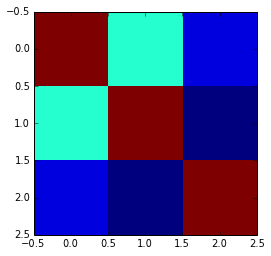

In [508]:
pylab.imshow(np.corrcoef(yMC,rowvar=1),interpolation='nearest')